# Auto-Config Tutorial

This colab walks through how to use Fiddle's "auto-config" functionality, building off of the [introductory](fiddle_tutorial_with_flax.ipynb) colab.

Auto-config allows existing "glue code" functions that perform object and function wire-up to be transformed into functions that capture the wire-up as a `fdl.Buildable`, often with no or very minimal changes to the existing code.

## Imports & model setup

As in the intro, we first import Fiddle, and then JAX and Flax as normal, and then define our model and model-building functions as if we didn't need to worry about configuration.

In [1]:
import dataclasses
import functools
from typing import Callable, List, Optional, Sequence, Tuple, Type

!pip install fiddle


import fiddle as fdl
from fiddle import graphviz
from fiddle.experimental import auto_config
import fiddle.extensions.jax

fiddle.extensions.jax.enable()

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn

In [3]:
class SimpleMLP(nn.Module):
  dense1: nn.Dense
  activation_fn: Callable[[jnp.array], jnp.array]
  dense2: nn.Dense

  def __call__(self, x):
    x = self.dense1(x)
    x = self.activation_fn(x)
    x = self.dense2(x)
    return x

In [4]:
# Write our model-building "glue code" as normal.
def make_model():
  return SimpleMLP(
      dense1=nn.Dense(features=10),
      activation_fn=nn.sigmoid,
      dense2=nn.Dense(features=1),
  )


model = make_model()
model

SimpleMLP(
    # attributes
    dense1 = Dense(
        # attributes
        features = 10
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
    activation_fn = sigmoid
    dense2 = Dense(
        # attributes
        features = 1
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
)

## Basic `auto_config` usage

In the introductory colab, we modified the `make_model()` function to add explicit calls to `fdl.Config` for each object we wanted to configure. Using auto-config, we don't need to change the code in `make_model()` at all! Instead, we can decorate the function with `auto_config` as follows:

In [5]:
@auto_config.auto_config
def make_model():
  return SimpleMLP(
      dense1=nn.Dense(features=10),
      activation_fn=nn.sigmoid,
      dense2=nn.Dense(features=1),
  )

The `auto_config` decorator adds an `as_buildable` attribute to the `make_model` function. This attribute is a function based on `make_model`, but with all calls to functions or classes are replaced by `fdl.Config` instances with the same arguments. Calling `make_model.as_buildable()` returns a `fdl.Buildable` instance that can be further mutated or built with `fdl.build`:

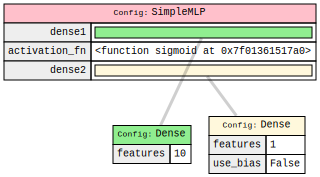

In [6]:
cfg = make_model.as_buildable()
cfg.dense2.use_bias = False
graphviz.render(cfg)

> Note: For additional documentation on the visualization used in this colab, see the [visualization, printing, and codegen colab](visualization_printing_codegen.ipynb).

In [7]:
model = fdl.build(cfg)
model

SimpleMLP(
    # attributes
    dense1 = Dense(
        # attributes
        features = 10
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
    activation_fn = sigmoid
    dense2 = Dense(
        # attributes
        features = 1
        use_bias = False
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
)

Note that because the "auto-configured" version of the function is only added to `make_model` via the `as_buildable` attribute, direct calls to `make_model` are unaffected:

In [8]:
make_model()

SimpleMLP(
    # attributes
    dense1 = Dense(
        # attributes
        features = 10
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
    activation_fn = sigmoid
    dense2 = Dense(
        # attributes
        features = 1
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
)

### As a standalone function

In addition to using `auto_config` as a decorator, it can also be called directly:

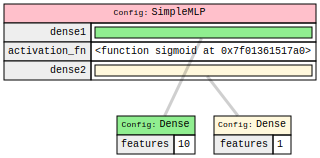

In [9]:
def make_model():
  return SimpleMLP(
      dense1=nn.Dense(features=10),
      activation_fn=nn.sigmoid,
      dense2=nn.Dense(features=1),
  )


cfg = auto_config.auto_config(make_model).as_buildable()
graphviz.render(cfg)

### Functions with arguments

If a function annotated with `auto_config` takes arguments, the `as_buildable` function will have the same signature:

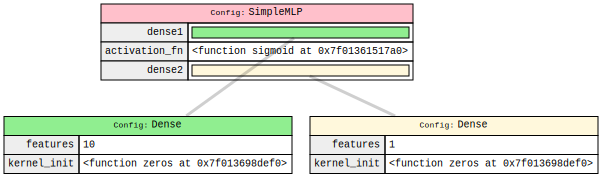

In [10]:
@auto_config.auto_config
def make_model(kernel_init=nn.initializers.lecun_normal()):
  return SimpleMLP(
      dense1=nn.Dense(features=10, kernel_init=kernel_init),
      activation_fn=nn.sigmoid,
      dense2=nn.Dense(features=1, kernel_init=kernel_init),
  )


cfg = make_model.as_buildable(kernel_init=nn.initializers.zeros)
graphviz.render(cfg)

### Creating `fdl.Partial` objects

When transforming a function, `auto_config` converts `functools.partial` calls into corresponding `fdl.Partial` instances. For example, we can make a model "factory" that uses a partially specified activation function as follows:

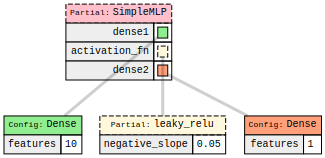

In [11]:
@auto_config.auto_config
def make_model_factory():
  return functools.partial(
      SimpleMLP,
      dense1=nn.Dense(features=10),
      activation_fn=functools.partial(nn.leaky_relu, negative_slope=0.05),
      dense2=nn.Dense(features=1),
  )


cfg = make_model_factory.as_buildable()
graphviz.render(cfg)

In [12]:
model_factory = fdl.build(cfg)
model = model_factory()  # This is now a factory, so we have to call it!
model

SimpleMLP(
    # attributes
    dense1 = Dense(
        # attributes
        features = 10
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
    activation_fn = functools.partial(<function leaky_relu at 0x7f01365703b0>, negative_slope=0.05)
    dense2 = Dense(
        # attributes
        features = 1
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
)

## Auto-config operation

Here we document how `auto_config` works in more detail, including specific transformation rules and compatiblity/limitations.

### Transformation rules

In general, `auto_config` transforms any "call" (function call or object creation) into a corresponding `fdl.Config` with the same arguments. However,
there are a few exceptions. Calls to the following kinds of objects are *not* transformed:

* builtin functions and classes like `range` or `list`;
* objects that have no `inspect.signature` (generally these are also builtins);
* methods;
* `fdl.Buildable` subclasses (including `fdl.TaggedValue`);
* functions with type annotations indicating their return type is a `fdl.Buildable` subclass;
* functions wrapped by `auto_config.exempt`, e.g. `auto_config.exempt(func)(arg1, arg2)`;
* other functions decorated with `@auto_config` (see full example below for additional details and usage).

Additionally, as mentioned above, calls to `functools.partial` are transformed into corresponding `fdl.Partial` objects instead of `fdl.Config` objects.

### Compatibility and limitations

Code that only performs function calls and object creation should be compatible with auto-config with few modifications. However, there are limitations that may require some changes to ensure compatibility:

* **Functions cannot contain any control flow**. At the moment this a restriction intended to encourage simplicity and predictability in functions that use auto-config, since some natural constructs (like using `itertools` functions in loop definitions) could have unexpected results. We are exploring  ways to support simple control flow constructs like `for` loops more robustly.

* **Code that relies on object instances, properties, or methods**. During execution of an auto-configured function, object creation calls are transformed into "unevaluated" `fdl.Config` instances. As a result, object instances (and hence their properties and methods) will not be available for subsequent code during execution of the function. A workaround is to use additional helper functions, as documented in the [intro colab](fiddle_tutorial_with_flax.ipynb) section on the computed value pattern.

* **Functions that return tuples or lists**. If a function returns a sequence, and only some elements of the sequence must be passed to subsequent functions, automatic "destructuring" of the return value isn't supported. A workaround is accessing the required elements or slices via lambdas, e.g. `(lambda t: t[0])(sequence_output)`.

* A subtle issue that can arise is that the order in which arguments are evaluated in the original function can differ from that of the `auto_config`-generated representation (which follows the order of arguments in the function signature).

### Internals

The basic mechanism of operation for `auto_config` is relatively simple, and the full [implementation][code] (~200 lines) can be consulted for additional details.

When given a function to transform, `auto_config` inspects the function's abstract syntax tree (AST) and modifies any call nodes (corresponding to a function call or object creation) to insert a "call handler" that intercepts calls during execution of the transformed function. The call handler then decides whether to create a `fdl.Config` object for the call (capturing the provided arguments), or forward the call to the original function or class. This decision is made according to the transformation rules below.

[code]: http://github.com/google/fiddle/tree/main/fiddle/experimental/auto_config.py

## Full example

Below we work out a more involved example implementing a basic regression setup in Flax relying on the behaviors documented above and demonstrating nested calls to `auto_config`ed functions.

### Additional training utilities

First, we define an MSE loss function and a (somewhat) generic `Trainer` utility class:

In [13]:
from flax.training import train_state
import optax


def mse_loss(y_true, y_pred):
  error = y_true - y_pred
  return jnp.mean(jnp.square(error))


@dataclasses.dataclass
class Trainer:
  rng: jax.random.PRNGKey
  model: nn.Module
  optimizer: optax.GradientTransformation
  loss_fn: Callable[[jnp.array, jnp.array], jnp.array]
  examples: List[Tuple[jnp.array, jnp.array]]
  state: train_state.TrainState = dataclasses.field(init=False)

  def __post_init__(self):
    inputs, _ = self.examples[0]
    params = self.model.init(self.rng, inputs)
    opt_state = self.optimizer.init(params)
    self.state = train_state.TrainState(
        step=0,
        apply_fn=self.model.apply,
        params=params,
        tx=self.optimizer,
        opt_state=opt_state)

  def train_step(self, state, x, y):

    def apply_loss(params):
      predictions = state.apply_fn(params, x)
      loss = self.loss_fn(y, predictions)
      return loss

    grad_fn = jax.value_and_grad(apply_loss)
    loss_val, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss_val

  def train_epoch(self):
    for x, y in self.examples:
      self.state, loss_val = self.train_step(self.state, x, y)
      print(self.state.step, loss_val)

### Wire-up using `auto_config`
Now we can create a basic configuration using `auto_config`:

In [14]:
@auto_config.auto_config
def make_model():
  return SimpleMLP(
      dense1=nn.Dense(features=10),
      activation_fn=functools.partial(nn.leaky_relu, negative_slope=0.02),
      dense2=nn.Dense(features=1),
  )


def make_data(key, num_batches, batch_size, input_dims):
  # Create random input data.
  x_batches = jax.random.normal(key, (num_batches, batch_size, input_dims))
  # Create a bunch of zero-valued regression targets.
  y_batches = jnp.zeros((num_batches, batch_size))
  # Zip together to create a list of (input, target) batches.
  return list(zip(x_batches, y_batches))


@auto_config.auto_config
def make_trainer():
  trainer = Trainer(
      rng=jax.random.PRNGKey(seed=42),
      model=make_model(),
      optimizer=optax.sgd(learning_rate=0.1),
      loss_fn=mse_loss,
      examples=make_data(
          jax.random.PRNGKey(seed=13),
          num_batches=10,
          batch_size=32,
          input_dims=20))
  return trainer

Per the transformation rules above, calls from one auto-configed function to another are *not* transformed (note that the other function must be *decorated* with `@auto_config` for this to work). This allows glue code to be factored as desired into reusable functions that build different components of an overall setup.

As a result, the call to `make_model` in `make_trainer` is effectively inlined. As you can see in the graph below, the `model` field for `Trainer` is a `SimpleMLP` which has several configurable sub-components.

However, we don't use `auto_config` for the `make_data` function! This means we will get a corresponding `fdl.Config` for `make_data`. To see this in action we can create the trainer config object and visualize it:

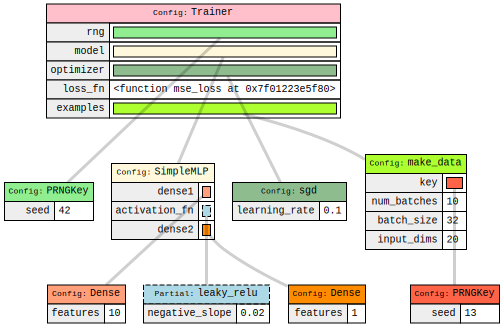

In [15]:
trainer_cfg = make_trainer.as_buildable()
graphviz.render(trainer_cfg)

This configuration can be built to obtain a usable `Trainer` instance:

In [16]:
trainer = fdl.build(trainer_cfg)
for i in range(3):
  print('epoch', i)
  trainer.train_epoch()

epoch 0
1 0.2838653
2 0.21803907
3 0.21047354
4 0.1979806
5 0.13222642
6 0.08255785
7 0.065112114
8 0.10107071
9 0.07565006
10 0.115647994
epoch 1
11 0.041579906
12 0.04145066
13 0.035830304
14 0.038941663
15 0.03961956
16 0.021673976
17 0.02404899
18 0.030386765
19 0.023090502
20 0.044453632
epoch 2
21 0.018582897
22 0.020650044
23 0.016066248
24 0.019190717
25 0.021523504
26 0.010438805
27 0.012974756
28 0.01596553
29 0.010962906
30 0.023893178



The trainer config can be used to try some additional experiments. For example, we can increase the learning rate to achieve faster convergence:

In [17]:
trainer_cfg.optimizer.learning_rate = 0.3
trainer = fdl.build(trainer_cfg)
for i in range(3):
  print('epoch', i)
  trainer.train_epoch()

epoch 0
1 0.2838653
2 0.12842616
3 0.10451946
4 0.06609689
5 0.047944777
6 0.017549392
7 0.023271974
8 0.02991738
9 0.013452936
10 0.022452662
epoch 1
11 0.011552879
12 0.013179112
13 0.009052264
14 0.009786806
15 0.011430102
16 0.0057634143
17 0.008019776
18 0.0087801
19 0.0060711047
20 0.017177094
epoch 2
21 0.021958068
22 0.0076652803
23 0.0039907256
24 0.003425775
25 0.0045710634
26 0.0025258493
27 0.0026390764
28 0.002829393
29 0.001680397
30 0.004811685
